- Kaggle : https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/overview
- Maker notes : https://www.notion.so/maker-NLP-00d265601ad146e490bea30cda512756

In [1]:
%load_ext autoreload
%autoreload 2

In [29]:
import sys
sys.path.append('..')

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from maker_nlp.preprocessing import clean_text

from tqdm import tqdm

DATA_FOLDER = Path('../data')
CLASS_NAMES = ['negative', 'neutral', 'positive']
#CLASS_NAMES = ['negative', 'somewhat negative', 'neutral', 'somewhat positive', 'positive']

## Dataset

### Load dataset

In [30]:
df = pd.read_csv(DATA_FOLDER / 'final_dataset.csv')
print(df.shape)
df.head()

(3995, 2)


,Phrase,Sentiment
0,"This quiet , introspective and entertaining in...",4
1,A comedy-drama of nearly epic proportions root...,4
2,The performances are an absolute joy .,4
3,Like a less dizzily gorgeous companion to Mr. ...,2
4,It 's everything you 'd expect -- but nothing ...,2


### Seperate dataset in train and test sets

In [31]:
X, y = df.Phrase, df.Sentiment
print(f'Shape of X = {X.shape}, Shape of y = {y.shape}')

Shape of X = (3995,), Shape of y = (3995,)


In [32]:
X_train_master, X_test_master, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)
X_train_master.shape, X_test_master.shape, y_train.shape, y_test.shape

((3196,), (799,), (3196,), (799,))

## Pre-processing & Feature engineering

### Lematisation

In [33]:
import en_core_web_sm

nlp = en_core_web_sm.load()

doc = nlp(u"Apples and oranges are similar. Boots and hippos aren't.")
for token in doc:    
    print(token, token.lemma_)

Apples apple
and and
oranges orange
are be
similar similar
. .
Boots boot
and and
hippos hippos
are be
n't not
. .


### Application of text cleaning

In [34]:
X_train = X_train_master.copy()
X_train.head()

2988    While Serving Sara does have a long way to go ...
1575                Loud , silly , stupid and pointless .
506              Instead , it 'll only put you to sleep .
3591    A finely tuned mood piece , a model of menacin...
3560    Too many improbabilities and rose-colored situ...
Name: Phrase, dtype: object

In [35]:
tqdm.pandas()

X_train = X_train.progress_apply(clean_text)
X_train.head()

/Users/najate.ochbouk@total.com/PycharmProjects/maker_nlp/venv/lib/python3.9/site-packages/tqdm/std.py:701: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 3196/3196 [00:21<00:00, 145.67it/s]


2988    serve sara long way reach level crudity late a...
1575                          loud silly stupid pointless
506                                    instead will sleep
3591     finely tune mood piece model menacing atmosphere
3560    improbability rise colored situation temper ve...
Name: Phrase, dtype: object

In [36]:
X_train.dropna(inplace = True)

In [37]:
X_train

2988    serve sara long way reach level crudity late a...
1575                          loud silly stupid pointless
506                                    instead will sleep
3591     finely tune mood piece model menacing atmosphere
3560    improbability rise colored situation temper ve...
                              ...                        
1130         piccoli give superb performance deep feeling
1294                overall interesting documentary imaxy
860     film spot s slippery footing acceptable entert...
3507    tian emphasize isolation character confine col...
3174                  year later e t cinematic touchstone
Name: Phrase, Length: 3196, dtype: object

### Transform dataset to a bag of words

In [38]:
count_vectorizer = TfidfVectorizer()

In [39]:
count_vectorizer.fit(X_train)

TfidfVectorizer()

In [40]:
X_train_count_features = count_vectorizer.transform(X_train)
X_train_count_features

<3196x7410 sparse matrix of type '<class 'numpy.float64'>'
	with 26397 stored elements in Compressed Sparse Row format>

## Modeling

In [41]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(random_state=42, max_iter=1000)

In [42]:
clf.fit(X_train_count_features, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Evaluation

### Preprocess test dataset

In [43]:
X_test = X_test_master.copy()
X_test = X_test.progress_apply(clean_text)

100%|██████████| 799/799 [00:05<00:00, 150.66it/s]


In [44]:
X_test_count_features = count_vectorizer.transform(X_test)
X_test_count_features

<799x7410 sparse matrix of type '<class 'numpy.float64'>'
	with 5446 stored elements in Compressed Sparse Row format>

### Compute predictions on test dataset

In [45]:
y_pred = clf.predict(X_test_count_features)
y_pred[:10]

array([0, 4, 4, 2, 2, 4, 4, 2, 2, 0])

### Evaluate model performance

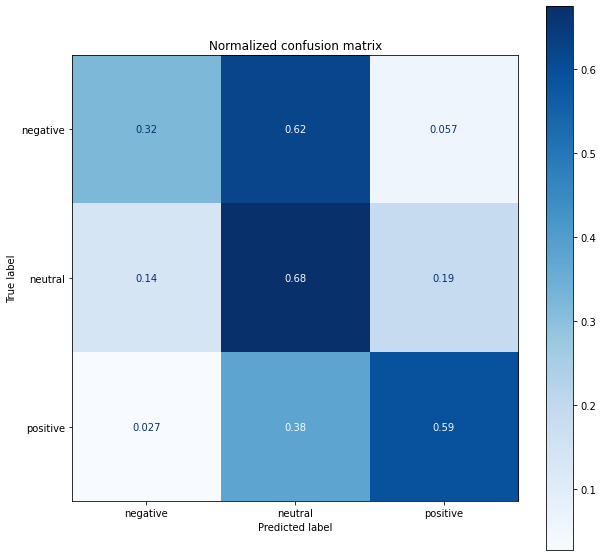

In [46]:
from sklearn.metrics import plot_confusion_matrix

np.set_printoptions(precision=2)
fig, ax = plt.subplots(figsize=(10, 10))
disp = plot_confusion_matrix(clf, X_test_count_features, y_test,
                             display_labels=CLASS_NAMES, cmap=plt.cm.Blues,
                             normalize='true', ax=ax)
disp.ax_.set_title('Normalized confusion matrix')
plt.show()